In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
from multiprocessing import cpu_count

## PENN Data

In [3]:
df = pd.read_csv('PENN.csv',sep=';')
Y_true_full = np.reshape(df['log_gdp'].values, (48,-1))
Y_true_full = Y_true_full.T
Y_true_full /= np.std(Y_true_full)
Y_true_full -= np.mean(Y_true_full)
N,T_total = Y_true_full.shape

democracy = np.reshape(df['dem'].values, (48,-1))
democracy = democracy.T

In [4]:
df

,country,year,log_gdp,dem,educ
0,Argentina,1960,0.459565,False,False
1,Australia,1960,0.945638,False,False
2,Austria,1960,0.637185,False,False
3,Burundi,1960,-1.749135,False,False
4,Belgium,1960,0.627998,False,False
...,...,...,...,...,...
5323,United States,2007,1.895453,True,True
5324,Venezuela (Bolivarian Republic of),2007,1.019204,False,False
5325,South Africa,2007,0.637374,False,False
5326,Zambia,2007,-0.610057,False,False


## Replicate SDID Table

In [5]:
np.argwhere(democracy==True)

array([[  1,  47],
       [  2,  47],
       [  4,  47],
       [ 11,  47],
       [ 13,  47],
       [ 15,  47],
       [ 24,  47],
       [ 25,  47],
       [ 27,  47],
       [ 32,  47],
       [ 34,  47],
       [ 36,  47],
       [ 38,  47],
       [ 44,  47],
       [ 51,  47],
       [ 53,  47],
       [ 54,  47],
       [ 55,  47],
       [ 58,  47],
       [ 63,  47],
       [ 64,  47],
       [ 68,  47],
       [ 78,  47],
       [ 79,  47],
       [ 81,  47],
       [ 86,  47],
       [105,  47],
       [106,  47],
       [110,  47]])

In [6]:
Ds = np.argwhere(democracy==True)[:,0]

In [8]:
assignment_vector = np.zeros((N,))
assignment_vector[Ds] = 1

In [9]:
assignment_vector

array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1.])

### Fit rank 4 factor model

In [10]:
def decompose_Y(Y,rank=4):
    N, T = Y.shape

    u,s,v = np.linalg.svd(Y)
    factor_unit = u[:,:rank]
    factor_time = v[:rank,:]
    L = np.dot(factor_unit*s[:rank],factor_time)
    E = Y - L
    F = np.add.outer(np.mean(L,axis=1),np.mean(L,axis=0)) - np.mean(L)
    M = L-F
    
    return F, M, E, factor_unit*np.sqrt(N)

### Fit AR(2) model

In [11]:
def fit_ar2(E):
    
    T_full = E.shape[1]
    E_ts = E[:, 2:]
    E_lag_1 = E[:, 1:-1]
    E_lag_2 = E[:,:-2]
    
    a_1 = np.sum(np.diag(np.matmul(E_lag_1, E_lag_1.T)))
    a_2 = np.sum(np.diag(np.matmul(E_lag_2, E_lag_2.T)))
    a_3 = np.sum(np.diag(np.matmul(E_lag_1, E_lag_2.T)))
    
    matrix_factor = np.array([[a_1, a_3], 
                         [a_3, a_2]])
    
    b_1 = np.sum(np.diag(np.matmul(E_lag_1, E_ts.T)))
    b_2 = np.sum(np.diag(np.matmul(E_lag_2, E_ts.T)))
    
    ar_coef = np.linalg.inv(matrix_factor).dot(np.array([b_1, b_2]))

    return ar_coef

### Correlation matrix

In [12]:
def ar2_correlation_matrix(ar_coef, T):
    
    result = np.zeros(T)
    result[0] = 1
    result[1] = ar_coef[0] / (1 - ar_coef[1])
    for t in range(2, T):
        result[t] = ar_coef[0] * result[t-1] + ar_coef[1] * result[t-2]
    
    index_matrix = np.abs(np.arange(T)[:, None] - np.arange(T))
    cor_matrix = result[index_matrix].reshape(T, T)
    
    return cor_matrix

In [13]:
F, M, E, unit_factors = decompose_Y(Y_true_full)

ar_coef = fit_ar2(E)

print(ar_coef)

cor_matrix = ar2_correlation_matrix(ar_coef, T_total)

scaled_sd = np.linalg.norm(E.T.dot(E)/N,ord='fro')/np.linalg.norm(cor_matrix,ord='fro')

cov_mat = cor_matrix*scaled_sd

from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(unit_factors, assignment_vector)
pi = model.predict_proba(unit_factors)[:,1]

[ 0.91305147 -0.22055675]


### Generate Data

In [14]:
def generate_data(F, M, cov_mat, pi):
    
    N, T_total = F.shape
    
    Y = F + M + np.random.multivariate_normal(mean = np.zeros((T_total,)), cov = cov_mat, size=N)
    
    #Y /= np.std(Y)
    #Y -= np.mean(Y)
    
    W = np.zeros((N,T_total))
    
    candidates = np.random.binomial(n=1,p=pi)
            
    #candidate = np.random.choice(np.squeeze(np.argwhere(candidates==1)))
    candidate = np.random.choice(N)
  
    W[candidate,-1] = 1
                        
    return Y, W, candidate

In [ ]:
SC_RMSEs = []
DID_RMSEs = []
SDID_RMSEs = []
DWCP_RMSEs = []
MC_RMSEs = []

for last_prediction_period in range(1):
    Y_true = Y_true_full[:,:T_total-last_prediction_period]
    N,T = Y_true.shape
    
    errors_sdid = []
    errors_dwcp = []
    errors_mc = []
    errors_sc = []
    errors_difp = []
    errors_did = []
    
    biases_sdid = []
    biases_dwcp = []
    biases_mc = []
    biases_sc = []
    biases_difp = []
    biases_did = []
     
    sdid_outcomes = []
    dwcp_outcomes = []

    for experiment in range(1000):
        
        np.random.seed(experiment*3)

        Y_true, W_test, i = generate_data(F, M, cov_mat, pi)
        N,T = Y_true.shape
        Y_test = np.multiply(Y_true,1-W_test)

        print('experiment', experiment, 'treated unit', i)
    
        W_test = np.zeros((N,T))
        W_test[i,-1] = 1
        Y_test = np.multiply(Y_true,(1-W_test))
        
        # SDID
        predicted_outcome = impute_entry(Y_test,W_test,i,T-1,
                                                      lambda_unit=1,lambda_time=0.275,lambda_nn=np.inf,sdid_weight=1)
        errors_sdid.append(np.abs(predicted_outcome-Y_true[i,T-1]))
        biases_sdid.append(predicted_outcome-Y_true[i,T-1])
        sdid_outcomes.append(predicted_outcome)
        
         
        # DWCP
        predicted_outcome = impute_entry(Y_test,W_test,i,T-1,
                                                  lambda_unit=5,lambda_time=0.16,lambda_nn=0.5,sdid_weight=0)
        errors_dwcp.append(np.abs(predicted_outcome-Y_true[i,T-1]))
        biases_dwcp.append(predicted_outcome-Y_true[i,T-1])
        dwcp_outcomes.append(predicted_outcome)
       
        # MC
        L=run_MCNNM(Y_test,np.argwhere(1-W_test), lambd=0.01, threshold = 1e-5, print_every= None, max_iters = 20000)
        errors_mc.append(np.abs(L[i,T-1]-Y_true[i,T-1]))
        biases_mc.append(L[i,T-1]-Y_true[i,T-1])
        
        # SC
        Y = np.concatenate([Y_true[:i,:],np.roll(Y_true[i:,:],axis=0,shift=-1)])
        predicted_outcome = SC(Y,intercept=False)[0][0]
        biases_sc.append(predicted_outcome-Y[-1,-1])
        errors_sc.append(np.abs(Y[-1,-1]-predicted_outcome))
        
        # DID 
        predicted_outcome = np.mean(Y[:-1,-1])-np.mean(Y[:-1,:-1])+np.mean(Y[-1,:-1])
        errors_did.append(np.abs(Y[-1,-1]-predicted_outcome))
        biases_did.append(predicted_outcome-Y[-1,-1])
        
        # DIFP
        pre_treatment_mean = np.mean(Y[:,:-1],axis=1)[:,None]
        predicted_outcome = SC(Y,intercept=True)[0][0]
        biases_difp.append(predicted_outcome-Y[-1,-1])
        errors_difp.append(np.abs(Y[-1,-1]-predicted_outcome))
        
    SDID_RMSE = np.sqrt(np.mean(np.square(errors_sdid)))
    DWCP_RMSE = np.sqrt(np.mean(np.square(errors_dwcp)))
    MC_RMSE = np.sqrt(np.mean(np.square(errors_mc)))
    SC_RMSE = np.sqrt(np.mean(np.square(errors_sc)))
    DID_RMSE = np.sqrt(np.mean(np.square(errors_did)))
    DIFP_RMSE = np.sqrt(np.mean(np.square(errors_difp)))
    
    SDID_BIAS = np.mean(biases_sdid)
    DWCP_BIAS = np.mean(biases_dwcp)
    MC_BIAS = np.mean(biases_mc)
    SC_BIAS = np.mean(biases_sc)
    DID_BIAS = np.mean(biases_did)
    DIFP_BIAS = np.mean(biases_difp)
    
    SDID_RMSEs.append(SDID_RMSE)
    DWCP_RMSEs.append(DWCP_RMSE)
    MC_RMSEs.append(MC_RMSE)
    SC_RMSEs.append(SC_RMSE)
    DID_RMSEs.append(DID_RMSE)

In [ ]:
print('period: ', T, 'SDID: ', SDID_RMSE,'DWCP: ', DWCP_RMSE, 'MC: ', MC_RMSE, 'SC: ', SC_RMSE, 'DID: ', DID_RMSE, 'DIFP:', DIFP_RMSE)

In [ ]:
print('period: ', T, 'SDID: ', SDID_BIAS,'DWCP: ', DWCP_BIAS, 'MC: ', MC_BIAS, 'SC: ', SC_BIAS, 'DID: ', DID_BIAS, 'DIFP:', DIFP_BIAS)

### Variants of DWCP

In [48]:
SC_RMSEs = []
DID_RMSEs = []
SDID_RMSEs = []
DWCP_RMSEs = []
MC_RMSEs = []

for last_prediction_period in range(1):
    Y_true = Y_true_full[:,:T_total-last_prediction_period]
    N,T = Y_true.shape
    
    errors_sdid = []
    errors_dwcp = []
    errors_mc = []
    errors_sc = []
    errors_difp = []
    errors_did = []
    
    biases_sdid = []
    biases_dwcp = []
    biases_mc = []
    biases_sc = []
    biases_difp = []
    biases_did = []
     
    sdid_outcomes = []
    dwcp_outcomes = []

    for experiment in range(1000):
        
        np.random.seed(experiment*3)

        Y_true, W_test, i = generate_data(F, M, cov_mat, pi)
        N,T = Y_true.shape
        Y_test = np.multiply(Y_true,1-W_test)

        print('experiment', experiment, 'treated unit', i)
    
    #for i in range(N):
        
        W_test = np.zeros((N,T))
        W_test[i,-1] = 1
        Y_test = np.multiply(Y_true,(1-W_test))
        
         
        # DWCP
        predicted_outcome = impute_entry(Y_test,W_test,i,T-1,
                                                  lambda_unit=0.742,lambda_time=2,lambda_nn=np.inf,sdid_weight=0)
        errors_dwcp.append(np.abs(predicted_outcome-Y_true[i,T-1]))
        biases_dwcp.append(predicted_outcome-Y_true[i,T-1])
        dwcp_outcomes.append(predicted_outcome)
       
        
    DWCP_RMSE = np.sqrt(np.mean(np.square(errors_dwcp)))
    
    DWCP_BIAS = np.mean(biases_dwcp)
   
    DWCP_RMSEs.append(DWCP_RMSE)

experiment 0 treated unit 20
experiment 1 treated unit 40
experiment 2 treated unit 17
experiment 3 treated unit 79
experiment 4 treated unit 88
experiment 5 treated unit 15
experiment 6 treated unit 66
experiment 7 treated unit 19
experiment 8 treated unit 62
experiment 9 treated unit 55
experiment 10 treated unit 64
experiment 11 treated unit 44
experiment 12 treated unit 101
experiment 13 treated unit 73
experiment 14 treated unit 70
experiment 15 treated unit 2
experiment 16 treated unit 68
experiment 17 treated unit 27
experiment 18 treated unit 62
experiment 19 treated unit 41
experiment 20 treated unit 94
experiment 21 treated unit 2
experiment 22 treated unit 20
experiment 23 treated unit 100
experiment 24 treated unit 91
experiment 25 treated unit 10
experiment 26 treated unit 97
experiment 27 treated unit 96
experiment 28 treated unit 64
experiment 29 treated unit 63
experiment 30 treated unit 107
experiment 31 treated unit 16
experiment 32 treated unit 52
experiment 33 treat

In [49]:
print('period: ', T, 'DWCP: ', DWCP_RMSE)

period:  48 DWCP:  0.05523470978812291


## SDID

In [16]:
def SC(outcome_matrix,intercept=False,regularization=False):

    #outcome matrix has dimension units*periods
    X = outcome_matrix[:-1,:-1].T
    y = outcome_matrix[-1,:-1].T

    times,units = X.shape

    #need to reshape features into 2D array
    X_predict = outcome_matrix[:-1,-1].reshape(1,-1)

    unit_weights = cp.Variable((units,),nonneg=True)
    constraints = [cp.sum(unit_weights)==1]
    #constraints = []

    if intercept == True:
        mu = cp.Variable(nonneg=True)
        if regularization == True:

            reg = np.var(X[1:,:]-X[:-1,:])

            objective = cp.sum_squares(y-X@unit_weights-mu) + reg*times*(cp.sum_squares(unit_weights))

        else:
            objective = cp.sum_squares(y-X@unit_weights-mu)

    else:
        objective = cp.sum_squares(y-X@unit_weights)

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)

    if intercept == True:
        predicted_outcome = X_predict.dot(unit_weights.value)+mu.value

    else:
        predicted_outcome = X_predict.dot(unit_weights.value)

    return predicted_outcome, unit_weights.value

In [17]:
def weighted_TWFE(Y,W,unit_index=-1,time_index=-1):
    units, times = Y.shape
    unit_effects = cp.Variable((1,units))
    time_effects = cp.Variable((1,times))
    unit_factor = cp.kron(np.ones((times,1)),unit_effects).T
    time_factor = cp.kron(np.ones((units,1)),time_effects)
    mu = cp.Variable()

    # polishing effect of OSQP results in not truly weighting by zero; use cp.sum_squares instead
    #objective = cp.sum(cp.multiply(cp.square(Y-unit_factor-time_factor),W))

    objective = cp.sum_squares(cp.multiply(Y-unit_factor-time_factor-mu,W))

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()

    objective_value = prob.value

    predicted_value = unit_effects.value[0][unit_index] + time_effects.value[0][time_index] + mu.value
    #print('time effect', time_effects.value[0][time_index])
    return predicted_value

## MC (see https://sidravi1.github.io/blog/2018/12/02/athey-s-matrix-completion-methods)

In [18]:
def shrink_lambda(A, lambd):

    S,Σ,R = np.linalg.svd(A, full_matrices=False)
    #print(Σ)

    Σ = Σ - lambd
    Σ[Σ < 0] = 0

    return S @ np.diag(Σ) @ R

In [19]:
def getPO(A, O):

    A_out = np.zeros_like(A)
    A_out[tuple(O.T)] = A[tuple(O.T)]

    return A_out

In [20]:
def getPOinv(A, O):

    A_out = A.copy()
    #print(tuple(O.T))
    A_out[tuple(O.T)] = 0

    return A_out

In [21]:
def run_MCNNM(Y_obs, O, lambd = 10, threshold = 0.01, print_every= None, max_iters = 20000):

    L_prev = getPOinv(Y_obs, O)
    change = 1000
    iters = 0

    while (change > threshold) and (iters < max_iters):
        
        PO = getPO(Y_obs, O)
        PO_inv = getPOinv(L_prev, O)

        L_star = PO + PO_inv
        L_new = shrink_lambda(L_star, lambd)

        change = np.linalg.norm((L_prev - L_new))

        L_prev = L_new
        iters += 1

        if (print_every is not None) and ((iters % print_every) == 0):
            print(loss, change, real_loss)

    return L_new

## cross validation with 1 standard deviation to select lambda

In [22]:
from sklearn.model_selection import KFold

def get_CV_score(Y_obs, O, lambd, n_folds = 4, verbose=False):

    kfold = KFold(n_splits=n_folds, shuffle=True)

    mse = 0
    for i, (Otr_idx, Otst_idx) in enumerate(kfold.split(O)):
        Otr = O[Otr_idx]
        Otst = O[Otst_idx]
        if verbose: print(".", end="")

        L = run_MCNNM(Y_obs, Otr, lambd, threshold = 1e-10, print_every= None, max_iters = 20000)

        mse += ((Y_obs[tuple(Otst.T)] - L[tuple(Otst.T)]) ** 2).sum()

    return mse / n_folds

In [23]:
def do_CV(Y_obs, O, lambdas = [5, 10, 20, 40], n_tries = 10, verbose=False):

    score = {}

    for t in range(n_tries):
        run_score = {}
        for l in lambdas:
            if verbose: print(f"lambda {l}:", end="")
            run_score[l] = get_CV_score(Y_obs, O, l, n_folds = 4, verbose=verbose)
            if verbose: print(f" : {run_score[l]}")
        score[t] = run_score
    return score

In [24]:
W = np.zeros((N,T_total))
W[-1,-1] = 1
Y_0 = np.multiply(Y_true_full,(1-W))

In [61]:
cv_score = do_CV(Y_0, np.argwhere(1-W), lambdas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], n_tries = 20)
cv_score_df = pd.DataFrame(cv_score)

In [62]:
cv_score_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0.1,8.018835,8.102925,8.280600,8.284323,7.894573,8.019401,8.450580,8.240592,7.987465,7.898319,8.009809,7.867561,8.283781,8.159514,7.961225,8.115057,7.750303,7.913312,7.804028,7.707878
0.2,7.722421,7.608915,7.714134,7.680338,7.799792,7.482629,8.024018,7.621348,7.643079,7.471253,7.890699,7.752871,7.867330,7.567191,7.740971,7.848718,7.561958,7.757116,7.698303,7.585910
0.3,7.618212,7.349667,7.293491,7.393245,7.267239,7.457647,7.247314,7.387039,7.563062,7.552506,7.252689,7.372197,7.439247,7.441544,7.389320,7.347520,7.207836,7.452240,7.354272,7.384689
0.4,7.163996,7.203442,6.928452,6.946997,7.261597,6.897794,7.048992,7.194540,7.173627,7.249521,7.157127,7.190422,6.981363,7.223090,7.167667,7.246580,7.066150,7.258350,7.007694,7.095010
0.5,7.206730,7.013726,6.926711,6.886968,7.017897,7.009340,7.009808,6.948136,7.062319,7.083337,6.799342,7.101862,6.957993,7.112284,6.924221,7.063992,7.059112,7.025830,7.083102,6.912906
0.6,7.027543,7.013931,6.868325,6.932252,7.375868,6.959162,6.916605,7.143171,7.003955,7.007531,7.154443,6.965481,6.961322,6.950278,6.903005,7.011812,6.980147,7.168588,7.003326,7.271434
0.7,6.890884,7.119114,7.098821,7.019250,7.098214,7.075442,7.027426,7.099543,7.057599,6.928977,6.873905,7.104392,7.030663,7.136239,7.029266,6.905397,7.115112,6.957923,7.263427,7.296884
0.8,7.238696,7.316232,7.089532,7.323163,7.018912,7.161971,6.960485,7.235420,7.206832,7.141457,6.998854,7.083391,7.055645,7.052458,7.164318,7.069473,7.383751,7.195327,7.232981,7.223772


In [63]:
np.mean(cv_score_df.values,axis=1)

array([8.03750393, 7.70194972, 7.38854879, 7.12312058, 7.01028082,
       7.03090879, 7.05642389, 7.15763338])

## Weighted TWFE with Nuclear Norm Penalizatoin

In [25]:
def weighted_TWFE_NN(Y,weights,lambda_nn,unit_index=-1,time_index=-1):
    units, times = Y.shape
    unit_effects = cp.Variable((1,units))
    time_effects = cp.Variable((1,times))
    L = cp.Variable((units,times))
    unit_factor = cp.kron(np.ones((times,1)),unit_effects).T
    time_factor = cp.kron(np.ones((units,1)),time_effects)

    objective = cp.sum_squares(cp.multiply(Y-unit_factor-time_factor-L,weights)) + lambda_nn*cp.norm(L, "nuc")

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()

    objective_value = prob.value

    predicted_value = unit_effects.value[0][unit_index] + time_effects.value[0][time_index] + L.value[unit_index,time_index]
   
    return predicted_value

In [26]:
def SDID_weights(Y_true, i, t):
    
    N,T = Y_true.shape
    
    np.random.seed(0)
    Y_V = np.concatenate([Y_true[:i,:],np.roll(Y_true[i:,:],axis=0,shift=-1)])
    Y = np.concatenate([Y_V.T[:t,:],np.roll(Y_V.T[t:,:],axis=0,shift=-1)]).T

    # unit weights
    unit_weights = np.ones((N,))
    unit_weights[:-1] = SC(Y,intercept=True,regularization=True)[1]

    # time weights
    time_weights = np.ones((T,))
    time_weights[:-1] = SC(Y.T,intercept=True,regularization=False)[1]

    unit_weights = np.concatenate([unit_weights[:i],np.roll(unit_weights[i:],shift=1)])
    time_weights = np.concatenate([time_weights[:t],np.roll(time_weights[t:],shift=1)])
    return unit_weights, time_weights

In [46]:
def impute_entry(Y,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight=1):
    
    N,T = Y.shape

    #dist_time
    dist_time = np.absolute(np.arange(T)-t)

    #dist_unit
    mask = np.ones((N, T))
    mask[:,t] = 0
    W_i = np.tile(W[i,:],(N,1))
    mask = mask*(1-W)*(1-W_i)
    A = np.sum(np.multiply(np.square(Y[i,:]-Y),mask),axis=1)
    B = np.sum(mask,axis=1)
    dist_unit = np.sqrt(A/B)
    
    #SDID weights
    delta_unit, delta_time = SDID_weights(Y,i,t)
    delta_sdid = np.outer(delta_unit,delta_time)
    delta_unit_SDID, delta_time = SDID_weights(Y,i,t)
    
    #distance-based weights
    delta_unit = np.exp(-lambda_unit*dist_unit)
    delta_time = np.exp(-lambda_time*dist_time)
    delta_dwcp = np.outer(delta_unit,delta_time)
    
    #delta = np.outer(delta_unit,delta_time)
    #delta = delta_dwcp
    delta = sdid_weight*delta_sdid + (1-sdid_weight)*delta_dwcp
    
    delta = np.outer(delta_unit_SDID, delta_time)

    # when (i,t) is control, need to exclude it explicitly
    included_entries = 1-W
    included_entries[i,t] = 0
    
    if lambda_nn == np.inf:
        predicted_outcome = weighted_TWFE(Y,np.multiply(included_entries,delta),unit_index=i,time_index=t)     
    else:   
        predicted_outcome = weighted_TWFE_NN(Y,np.multiply(included_entries,delta),lambda_nn,unit_index=i,time_index=t)

    return predicted_outcome


In [30]:
def estimation_error(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight):
    predicted_outcome = impute_entry(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight)
    squared_error = np.square(predicted_outcome-Y_0[i,t])
    return squared_error

# Run Methods for Last 10 Periods

In [41]:
SC_RMSEs = []
DID_RMSEs = []
SDID_RMSEs = []
DWCP_RMSEs = []
MC_RMSEs = []

for last_prediction_period in range(10):
    Y_true = Y_true_full[:,:T_total-last_prediction_period]
    N,T = Y_true.shape
    
    errors_sdid = []
    errors_dwcp = []
    errors_mc = []
    errors_sc = []
    errors_did = []
     
    sdid_outcomes = []
    dwcp_outcomes = []

    for i in range(N):
        
        W_test = np.zeros((N,T))
        W_test[i,-1] = 1
        Y_test = np.multiply(Y_true,(1-W_test))
        
        # SDID
        predicted_outcome = impute_entry(Y_test,W_test,i,T-1,
                                                      lambda_unit=1,lambda_time=0.275,lambda_nn=np.inf,sdid_weight=1)
        errors_sdid.append(np.abs(predicted_outcome-Y_true[i,T-1]))
        sdid_outcomes.append(predicted_outcome)
        
        # DWCP
        predicted_outcome = impute_entry(Y_test,W_test,i,T-1,
                                                  lambda_unit=1.7,lambda_time=0.25,lambda_nn=0.4,sdid_weight=0)
        errors_dwcp.append(np.abs(predicted_outcome-Y_true[i,T-1]))
        dwcp_outcomes.append(predicted_outcome)
        
        # MC
        L=run_MCNNM(Y_test,np.argwhere(1-W_test), lambd=0.5, threshold = 1e-5, print_every= None, max_iters = 20000)
        errors_mc.append(np.abs(L[i,T-1]-Y_true[i,T-1]))
        
        # SC
        Y = np.concatenate([Y_true[:i,:],np.roll(Y_true[i:,:],axis=0,shift=-1)])
        predicted_outcome = SC(Y,intercept=False)[0][0]
        errors_sc.append(np.abs(Y[-1,-1]-predicted_outcome))
        
        # DID 
        predicted_outcome = np.mean(Y[:-1,-1])-np.mean(Y[:-1,:-1])+np.mean(Y[-1,:-1])
        errors_did.append(np.abs(Y[-1,-1]-predicted_outcome))
        
    SDID_RMSE = np.sqrt(np.mean(np.square(errors_sdid)))
    DWCP_RMSE = np.sqrt(np.mean(np.square(errors_dwcp)))
    MC_RMSE = np.sqrt(np.mean(np.square(errors_mc)))
    SC_RMSE = np.sqrt(np.mean(np.square(errors_sc)))
    DID_RMSE = np.sqrt(np.mean(np.square(errors_did)))
    
    SDID_RMSEs.append(SDID_RMSE)
    DWCP_RMSEs.append(DWCP_RMSE)
    MC_RMSEs.append(MC_RMSE)
    SC_RMSEs.append(SC_RMSE)
    DID_RMSEs.append(DID_RMSE)

    print('period: ', T, 'SDID: ', SDID_RMSE,'DWCP: ', DWCP_RMSE, 'MC: ', MC_RMSE, 'SC: ', SC_RMSE, 'DID: ', DID_RMSE)

KeyboardInterrupt: 

In [26]:
print('overall:', 'SDID: ', np.sqrt(np.mean(np.square(SDID_RMSEs))),'DWCP: ',
      np.sqrt(np.mean(np.square(DWCP_RMSEs))), 'MC: ', np.sqrt(np.mean(np.square(MC_RMSEs))),
      'SC: ', np.sqrt(np.mean(np.square(SC_RMSEs))), 'DID: ', np.sqrt(np.mean(np.square(DID_RMSEs))))

overall: SDID:  0.11766215323470558 DWCP:  0.10598344618220255 MC:  0.11763446713342975 SC:  0.12138655427293063 DID:  0.14485304615372688


# Optimal Tuning Parameter

In [14]:
Y_0 = Y_true_full[:,:-9]
W = np.zeros(Y_0.shape)
W[-1,-1] = 1
Y_0 = np.multiply(Y_0,(1-W))

In [18]:
Y_0 = Y_test
W = W_test

## Select lambda_unit

In [29]:
Q = []
lambda_units = np.arange(0,3,3/20)
for lambda_unit in lambda_units:
    lambda_time = 3
    lambda_nn = 0.3
    print(lambda_nn,lambda_unit,lambda_time)
    squared_errors = Parallel(n_jobs=36, prefer='processes')(
            delayed(estimation_error)(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight=0)
            for (i,t) in (np.argwhere(W == 0)))
    Q.append(np.sqrt(np.mean(squared_errors)))
    print(np.sqrt(np.mean(squared_errors)))

0.3 0.0 3
0.03475731653295962
0.3 0.15 3
0.034697570169008395
0.3 0.3 3
0.03466288715402311
0.3 0.44999999999999996 3
0.034648268546536284
0.3 0.6 3
0.03464826371288982
0.3 0.75 3
0.03465819865613299
0.3 0.8999999999999999 3
0.034674632596507944
0.3 1.05 3
0.034695278909022326
0.3 1.2 3


Process LokyProcess-2:
/home/users/zhaonanq/.local/lib/python3.9/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Traceback (most recent call last):
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/users/zhaonanq/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 510, in _process_worker
    gc.collect()
KeyboardInterrupt
Process LokyProcess-1:
Traceback (most recent call last):
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.9.0/lib/pyth

KeyboardInterrupt: 

In [ ]:
lambda_units[np.argmin(Q)]

In [ ]:
plt.plot(lambda_units,Q)
plt.xlabel('lambda_unit')
plt.ylabel('Q value')
plt.title('Q function for CPS data using SDID time weights')
plt.show()

## Select lambda_time

In [33]:
Q = []
lambda_times = np.arange(2.5,5,2.5/10)
for lambda_time in lambda_times:
    lambda_nn = 0.3
    lambda_unit = 0.6
    print(lambda_nn,lambda_unit,lambda_time)
    squared_errors = Parallel(n_jobs=36, prefer='processes')(
            delayed(estimation_error)(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight=0)
            for (i,t) in (np.argwhere(W == 0)))
    Q.append(np.sqrt(np.mean(squared_errors)))
    print(np.sqrt(np.mean(squared_errors)))

0.3 0.6 2.5
0.03468148452524618
0.3 0.6 2.75
0.03466071369971928
0.3 0.6 3.0


Process LokyProcess-67:
Traceback (most recent call last):
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/share/software/user/open/python/3.9.0/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/users/zhaonanq/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 510, in _process_worker
    gc.collect()
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
lambda_times[np.argmin(Q)]

In [ ]:
plt.plot(lambda_times,Q)
plt.xlabel('lambda_time')
plt.ylabel('Q value')
plt.title('Q function for CPS data using SDID unit weights')
plt.show()

## Select lambad_nn

In [51]:
Q = []
lambda_nns = np.arange(0.001,1,1/10)
for lambda_nn in lambda_nns:
    lambda_time = 0.16
    lambda_unit = 2.7
    print(lambda_nn,lambda_unit,lambda_time)
    squared_errors = Parallel(n_jobs=36, prefer='processes')(
            delayed(estimation_error)(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight=0)
            for (i,t) in (np.argwhere(W == 0)))
    Q.append(np.sqrt(np.mean(squared_errors)))
    print(np.sqrt(np.mean(squared_errors)))

0.001 2.7 0.16
0.12702334223993242
0.101 2.7 0.16
0.11715642422166486
0.201 2.7 0.16
0.11361647336016331
0.30100000000000005 2.7 0.16
0.10907700820629382
0.401 2.7 0.16
0.1070548328174259
0.501 2.7 0.16
0.10698580908106489
0.6010000000000001 2.7 0.16
0.1070294500083306
0.7010000000000001 2.7 0.16
0.10702906774647643
0.801 2.7 0.16
0.10702907069406029
0.901 2.7 0.16
0.10702906656186077


In [52]:
lambda_nns[np.argmin(Q)]

0.501

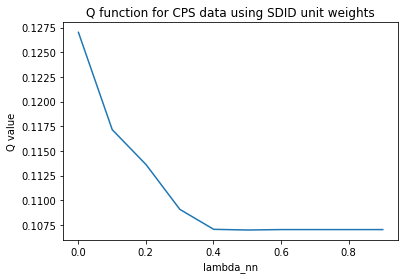

In [53]:
plt.plot(lambda_nns,Q)
plt.xlabel('lambda_nn')
plt.ylabel('Q value')
plt.title('Q function for CPS data using SDID unit weights')
plt.show()

In [54]:
Q

[0.12702334223993242,
 0.11715642422166486,
 0.11361647336016331,
 0.10907700820629382,
 0.1070548328174259,
 0.10698580908106489,
 0.1070294500083306,
 0.10702906774647643,
 0.10702907069406029,
 0.10702906656186077]

## SDID and DWCP Predictions

In [87]:
Y_true = Y_true_full[:,:-8]
N, T = Y_true.shape

In [88]:
errors_sdid = []
sdid_outcomes = []

for i in range(N):
    W_test = np.zeros((N,T))
    W_test[i,-1] = 1
    Y_test = np.multiply(Y_true,(1-W_test))
    predicted_outcome = impute_entry(Y_test,W_test,i,T-1,
                                                  lambda_unit=1.7,lambda_time=0.25,lambda_nn=np.inf,sdid_weight=1)
    errors_sdid.append(np.abs(predicted_outcome-Y_true[i,T-1]))
    sdid_outcomes.append(predicted_outcome)

In [89]:
np.sqrt(np.mean(np.square(errors_sdid)))

0.09986461257341435

In [96]:
errors_dwcp = []
dwcp_outcomes = []
for i in range(N):
    W_test = np.zeros((N,T))
    W_test[i,-1] = 1
    Y_test = np.multiply(Y_true,(1-W_test))
    predicted_outcome = impute_entry(Y_test,W_test,i,T-1,
                                                  lambda_unit=1,lambda_time=0.275,lambda_nn=0.4,sdid_weight=0)
    errors_dwcp.append(np.abs(predicted_outcome-Y_true[i,T-1]))
    dwcp_outcomes.append(predicted_outcome)

In [97]:
np.sqrt(np.mean(np.square(errors_dwcp)))

0.10181503479965778